In [28]:
# Libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
import os
from PIL import Image
import scipy.spatial
import time

In [29]:
output_path = '/kaggle/working/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [30]:
# Process to create GIF
def create_gif(name, output_dir, k, initialize, max_iter):
    """
    Create a GIF from the saved clustering images.
    Args:
        output_dir (str): Directory where images are saved.
        max_iter (int): Total number of iterations visualized.
    """
    images = []
    output_dir = os.path.join(output_dir, name)
    for i in range(max_iter):
        filename = os.path.join(output_dir, f'nb_cluster{k}_iteration_{i}_init_{initialize}.png')
        if not os.path.exists(filename):
            continue
        images.append(imageio.imread(filename))
    if images:
        gif_filename = os.path.join(output_dir, f'clustering_{name}_nb_cluster{k}_init_{initialize}.gif')
        imageio.mimsave(gif_filename, images, duration=0.5)
        print(f"GIF saved at {gif_filename}")

def save_iteration_visualization(name, img_shape, clusters, k, iteration, initialize, output_dir):
    """
    Save the cluster assignment visualization for the current iteration.
    Args:
        img_shape (tuple): Shape of the original image (height, width, channels).
        clusters (numpy.ndarray): Cluster assignments for each pixel.
        k (int): Number of clusters.
        iteration (int): Current iteration number.
        output_dir (str): Directory to save the images.
    """
    output_dir = os.path.join(output_dir, name)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    H, W, _ = img_shape
    cluster_image = clusters.reshape(H, W)
    plt.figure(figsize=(8, 6))
    plt.imshow(cluster_image, cmap='tab20', interpolation='nearest')
    plt.title(f'Iteration {iteration}')
    plt.axis('off')
    filename = os.path.join(output_dir, f'nb_cluster{k}_iteration_{iteration}_init_{initialize}.png')
    plt.savefig(filename, bbox_inches='tight')
    plt.close()

In [31]:
def kernel(image):
	gamma_s = 1 / (100 * 100)
	gamma_c = 1 / (100 * 100)
	coor = []
	for i in range(100):
		for j in range(100):
			coor.append([i, j])
	coor = np.array(coor)
	s = np.exp(-gamma_s * scipy.spatial.distance.cdist(coor, coor, 'sqeuclidean'))
	c = np.exp(-gamma_c * scipy.spatial.distance.cdist(image, image, 'sqeuclidean'))
	return s * c

In [32]:
def initialize_clusters(data, k, method="random"):
    """
    Initialize cluster centroids using random initialization or k-means++.
    Parameters:
    - data (numpy.ndarray): The dataset (n_samples, n_features).
    - k (int): The number of clusters.
    - method (str): Initialization method ("random" or "kmeans++").
    Returns:
    - numpy.ndarray: Initialized centroids of shape (k, n_features).
    """
    n_samples, n_features = data.shape

    if method == "random":
        # Random initialization: randomly select k points from the dataset as centroids
        indices = np.random.choice(n_samples, k, replace=False)
        return data[indices]

    elif method == "kmeans++":
        # K-means++ initialization
        centroids = [data[np.random.randint(0, n_samples)]]
        for _ in range(1, k):
            distances = np.min([np.linalg.norm(data - centroid, axis=1) for centroid in centroids], axis=0)
            probs = distances / np.sum(distances)
            new_centroid = data[np.random.choice(n_samples, p=probs)]
            centroids.append(new_centroid)
        return np.array(centroids)

    else:
        raise ValueError("Invalid method! Use 'random' or 'kmeans++'.")

def kmeans(data, k, max_iter=100, tol=1e-4, init_method="random", save_callback=None):
    """
    Perform K-means clustering with optional saving of intermediate results.
    Parameters:
    - data (numpy.ndarray): The dataset (n_samples, n_features).
    - k (int): The number of clusters.
    - max_iter (int): Maximum number of iterations.
    - tol (float): Tolerance for convergence.
    - init_method (str): Initialization method ("random" or "kmeans++").
    - save_callback (function): Optional callback to save visualizations during iterations.
    Returns:
    - numpy.ndarray: Cluster assignments of shape (n_samples,).
    - numpy.ndarray: Final centroids of shape (k, n_features).
    """
    centroids = initialize_clusters(data, k, method=init_method)
    for iteration in range(max_iter):
        # Assign clusters based on closest centroid
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        clusters = np.argmin(distances, axis=1)

        # Save visualization if callback is provided
        if save_callback:
            save_callback(clusters, iteration)

        # Update centroids
        new_centroids = np.array([data[clusters == c].mean(axis=0) if np.any(clusters == c) else centroids[c] for c in range(k)])

        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids

    return clusters, centroids

In [33]:
def visualize_clusters(image, clusters, title="Clustered Image"):
    """
    Visualize the clustered image.
    Parameters:
    - image (numpy.ndarray): Original image (h, w, channels).
    - clusters (numpy.ndarray): Cluster assignments of shape (h*w,).
    - title (str): Title for the plot.
    """
    h, w = image.shape[:2]
    clustered_image = clusters.reshape(h, w)
    plt.figure(figsize=(8, 8))
    plt.imshow(clustered_image, cmap="tab20")
    plt.title(title)
    plt.axis("off")
    plt.show()

def visualize_eigen_space(U, clusters, k, name, method, output_path, init):
    """
    Visualize the data points in the eigen-space of the graph Laplacian.

    Parameters:
    - U (numpy.ndarray): Eigenvectors used for clustering.
    - clusters (numpy.ndarray): Cluster assignments.
    - k (int): Number of clusters.
    - name (str): Name for saving the plot.
    - method (str): Clustering method used.
    - output_path (str): Path to save the output plots.
    """
    # Create the directory if it doesn't exist
    directory = os.path.join(output_path, name)
    os.makedirs(directory, exist_ok=True)
    
    # Define a colormap
    cmap = plt.get_cmap('viridis', k)
    
    if k > 3:
        print("Cannot visualize more than 3 dimensions.")
        return
    
    if k <= 2:
        plt.figure(figsize=(8, 6))
        for cluster_idx in range(k):
            cluster_data = U[clusters == cluster_idx]
            plt.scatter(cluster_data[:, 0], cluster_data[:, 1],
                        label=f'Cluster {cluster_idx}', color=cmap(cluster_idx))
        plt.title(f'Data Points in Eigen-space: {name}_{init}')
        plt.xlabel('First Eigenvector')
        plt.ylabel('Second Eigenvector')
        plt.legend()
        plt.tight_layout()
        plot_filename = f'eigen_space_{name}_{k}_{init}.png'
        plt.savefig(os.path.join(directory, plot_filename))
        plt.show()
        
    elif k == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for cluster_idx in range(k):
            cluster_data = U[clusters == cluster_idx]
            ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2],
                       label=f'Cluster {cluster_idx}', color=cmap(cluster_idx))
        ax.set_title(f'Data Points in Eigen-space: {name}_{init}')
        ax.set_xlabel('First Eigenvector')
        ax.set_ylabel('Second Eigenvector')
        ax.set_zlabel('Third Eigenvector')
        ax.legend()
        # Set a default view angle for better visualization
        ax.view_init(elev=30, azim=45)
        plt.tight_layout()
        plot_filename = f'eigen_space_{name}_{k}_{init}.png'
        plt.savefig(os.path.join(directory, plot_filename))
        plt.show()


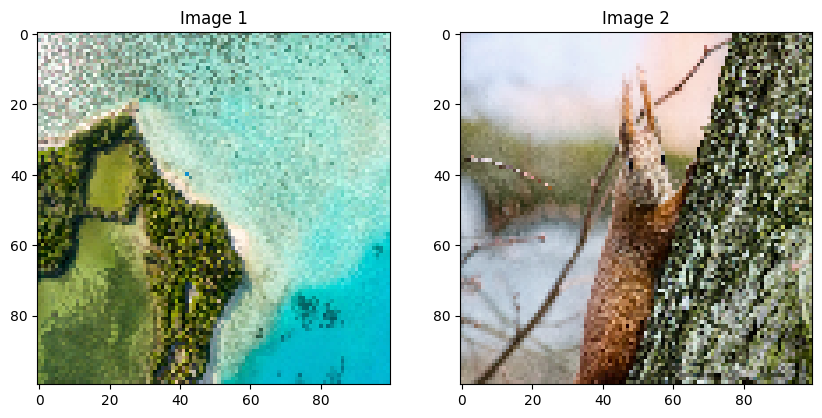

In [34]:
# Data: 2 images
path_img1 = "/kaggle/input/images-hw6/image1.png"
path_img2 = "/kaggle/input/images-hw6/image2.png"

img1 = cv2.imread(path_img1)
img2 = cv2.imread(path_img2)

# visualisation
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Image 1")
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("Image 2")
plt.show()

In [35]:
print("Computing Similarity Matrix for Image 1...")
similarity_matrix1 = kernel(img1.reshape(-1, 3))
print("Computing Similarity Matrix for Image 2...")
similarity_matrix2 = kernel(img2.reshape(-1, 3))

Computing Similarity Matrix for Image 1...
Computing Similarity Matrix for Image 2...


In [36]:
import numpy as np

def compute_eigen_normalized(similarity_matrix):
    """
    Compute the normalized Laplacian and its eigenvectors.
    """
    print("Computing Degree matrix and Laplacian...")
    
    # Compute Degree matrix
    D = np.diag(np.sum(similarity_matrix, axis=1))

    # Compute normalized Laplacian
    L = D - similarity_matrix
    D_inv_sqrt = np.diag(1 / np.sqrt(np.diag(D) + 1e-10))
    n = 100*100
    L_sym = np.eye(n) - D_inv_sqrt @ similarity_matrix @ D_inv_sqrt 

    # Compute eigenvectors of L_sym
    print("Computing Eigen vectors...")
    eigenvalues, eigenvectors = np.linalg.eigh(L_sym)

    return eigenvalues, eigenvectors

def normalized_spectral_clustering(
    eigenvalues, 
    eigenvectors,
    k,
    max_iter=100,
    tol=1e-6,
    init_method="random",
    output_dir="output",
    name="img",
    img_shape=None
):
    index = np.argsort(eigenvalues)
    eigenvectors = eigenvectors[:, index]
    U = eigenvectors[:, 1:1+k].real  # Take the first k eigenvectors

    # Row normalize U
    T = U / np.linalg.norm(U, axis=1, keepdims=True)
    
    # Define a save callback function
    def save_callback(clusters, iteration):
        if img_shape is not None:
            save_iteration_visualization(
                name, img_shape, clusters, k, iteration, init_method, output_dir
            )

    # Apply k-means to rows of T
    print("Performing K-Means...")
    clusters, _ = kmeans(
        T,
        k,
        max_iter=max_iter,
        tol=tol,
        init_method=init_method,
        save_callback=save_callback
    )

    # Visualize Eigen-space
    visualize_eigen_space(T, clusters, k, f"{name}_Normalized_Cut", init_method, output_dir,init_method)

    return clusters


Computing Degree matrix and Laplacian...
Computing Eigen vectors...
Eigenvalues and vectors done for img 1!
Computing Degree matrix and Laplacian...
Computing Eigen vectors...
Eigenvalues and vectors done for img 2!
Normalized Clustering for image 1 for 2 with random initialization:
Performing K-Means...


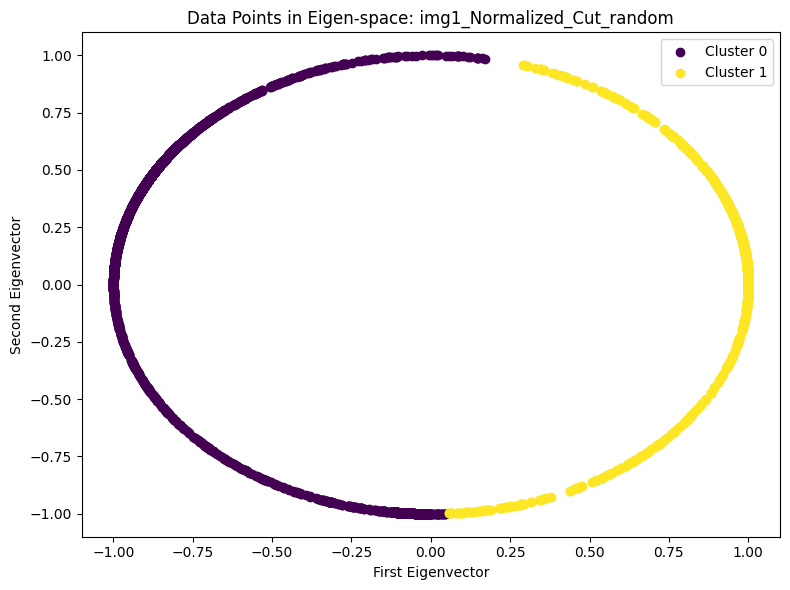

/tmp/ipykernel_24/1561842593.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


GIF saved at /kaggle/working/img1/clustering_img1_nb_cluster2_init_random.gif
Image 1 clustering done for 2clusters, initializing with random centers
Normalized Clustering for image 2 for 2 withrandom initialization:
Performing K-Means...


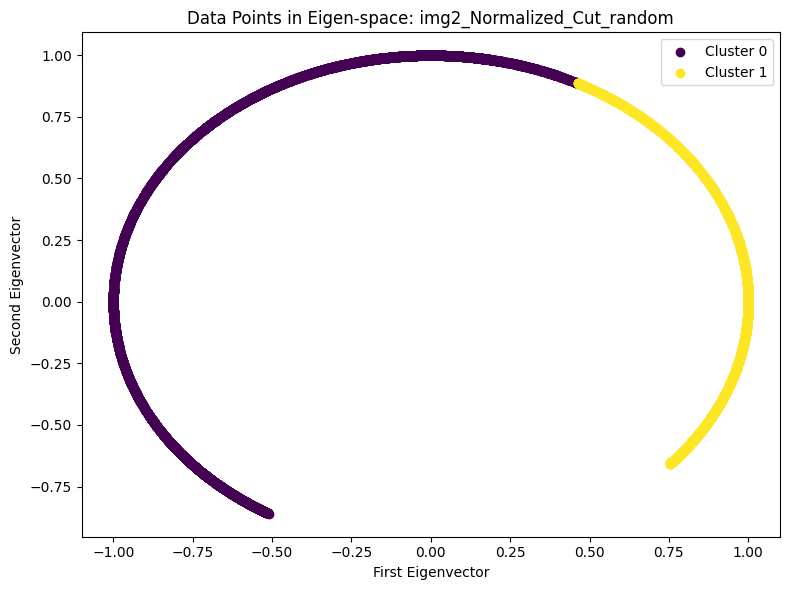

GIF saved at /kaggle/working/img2/clustering_img2_nb_cluster2_init_random.gif
Image 1 clustering done for 2clusters, initializing with random centers


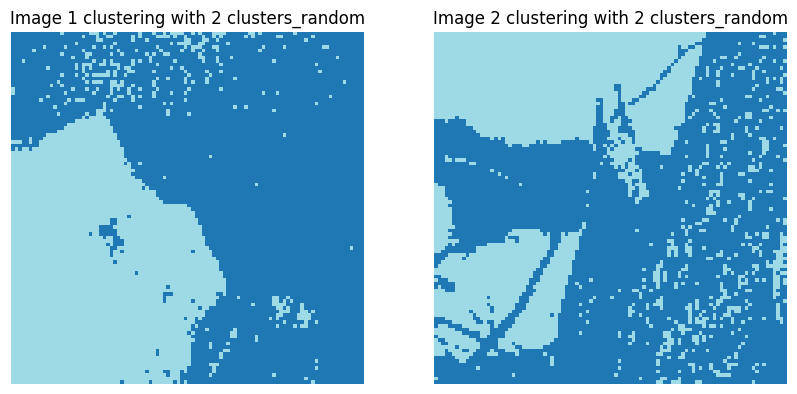

Time taken for k=2, initialization=random: 8.94 seconds
Normalized Clustering for image 1 for 2 with kmeans++ initialization:
Performing K-Means...


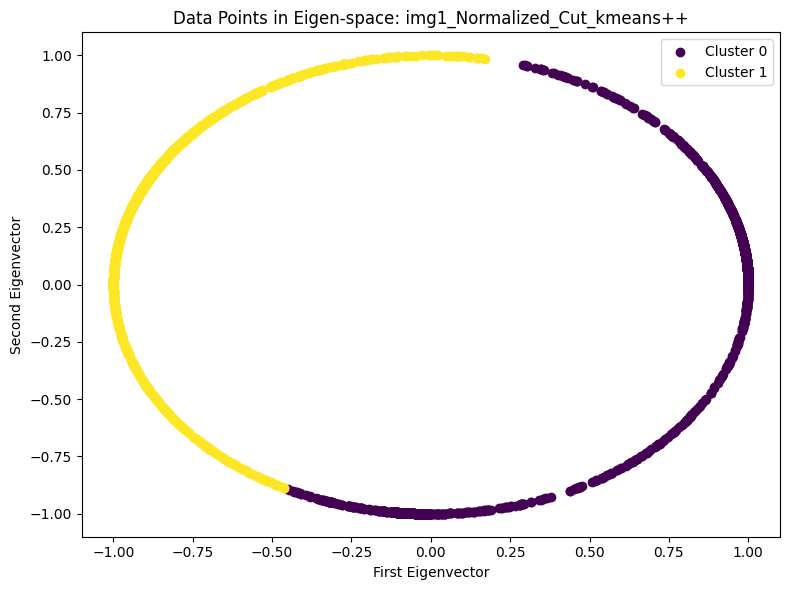

GIF saved at /kaggle/working/img1/clustering_img1_nb_cluster2_init_kmeans++.gif
Image 1 clustering done for 2clusters, initializing with random centers
Normalized Clustering for image 2 for 2 withkmeans++ initialization:
Performing K-Means...


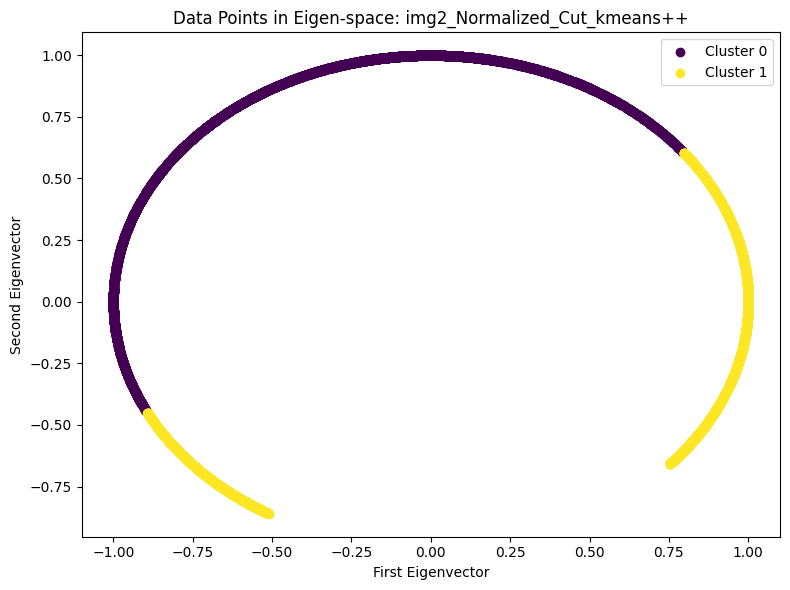

GIF saved at /kaggle/working/img2/clustering_img2_nb_cluster2_init_kmeans++.gif
Image 1 clustering done for 2clusters, initializing with random centers


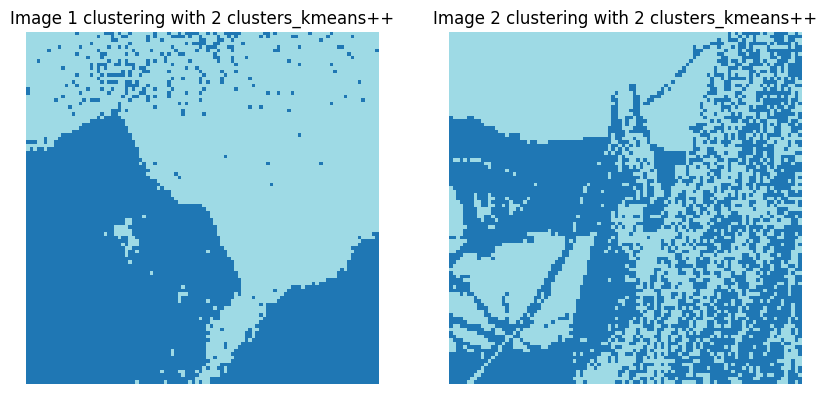

Time taken for k=2, initialization=kmeans++: 8.54 seconds
Normalized Clustering for image 1 for 3 with random initialization:
Performing K-Means...


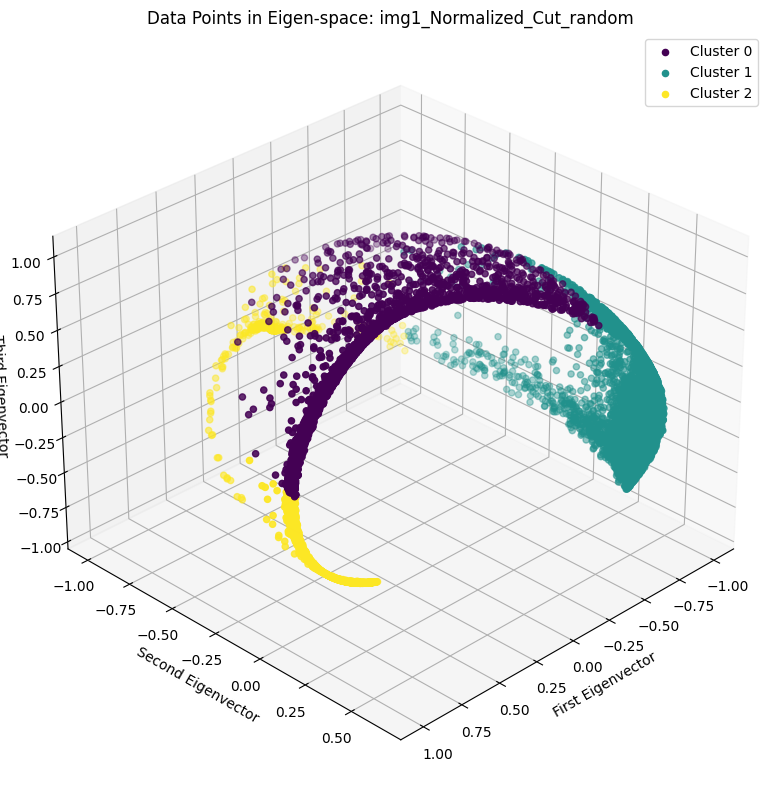

GIF saved at /kaggle/working/img1/clustering_img1_nb_cluster3_init_random.gif
Image 1 clustering done for 3clusters, initializing with random centers
Normalized Clustering for image 2 for 3 withrandom initialization:
Performing K-Means...


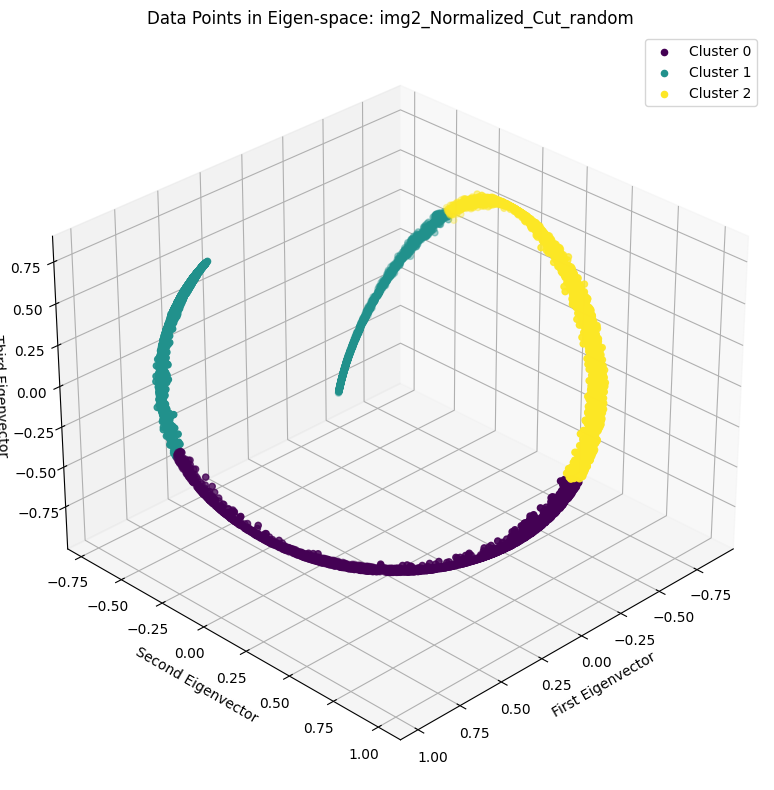

GIF saved at /kaggle/working/img2/clustering_img2_nb_cluster3_init_random.gif
Image 1 clustering done for 3clusters, initializing with random centers


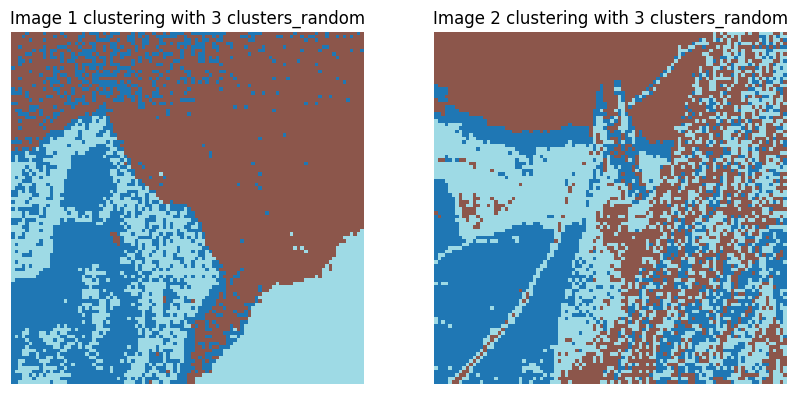

Time taken for k=3, initialization=random: 13.18 seconds
Normalized Clustering for image 1 for 3 with kmeans++ initialization:
Performing K-Means...


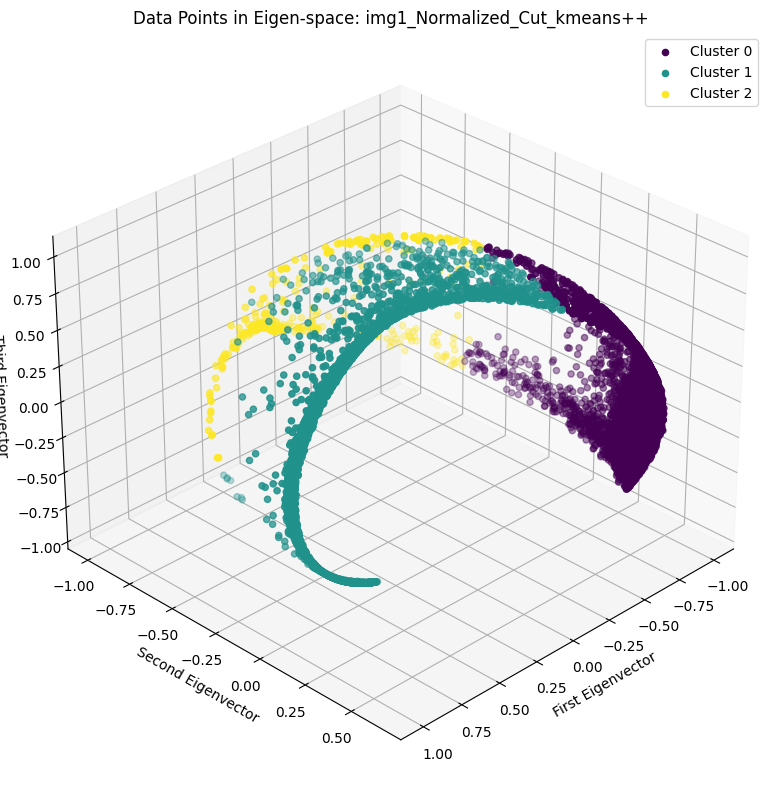

GIF saved at /kaggle/working/img1/clustering_img1_nb_cluster3_init_kmeans++.gif
Image 1 clustering done for 3clusters, initializing with random centers
Normalized Clustering for image 2 for 3 withkmeans++ initialization:
Performing K-Means...


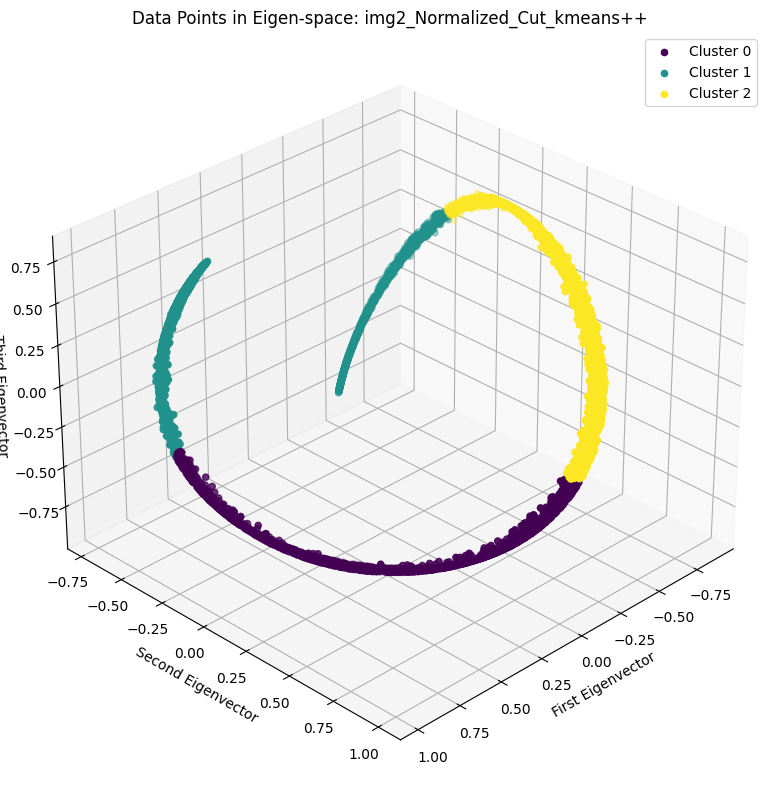

GIF saved at /kaggle/working/img2/clustering_img2_nb_cluster3_init_kmeans++.gif
Image 1 clustering done for 3clusters, initializing with random centers


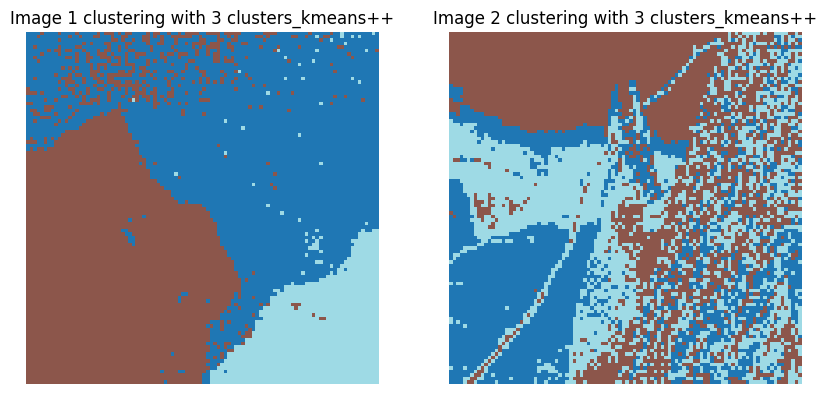

Time taken for k=3, initialization=kmeans++: 11.83 seconds
Normalized Clustering for image 1 for 4 with random initialization:
Performing K-Means...
Cannot visualize more than 3 dimensions.
GIF saved at /kaggle/working/img1/clustering_img1_nb_cluster4_init_random.gif
Image 1 clustering done for 4clusters, initializing with random centers
Normalized Clustering for image 2 for 4 withrandom initialization:
Performing K-Means...
Cannot visualize more than 3 dimensions.
GIF saved at /kaggle/working/img2/clustering_img2_nb_cluster4_init_random.gif
Image 1 clustering done for 4clusters, initializing with random centers


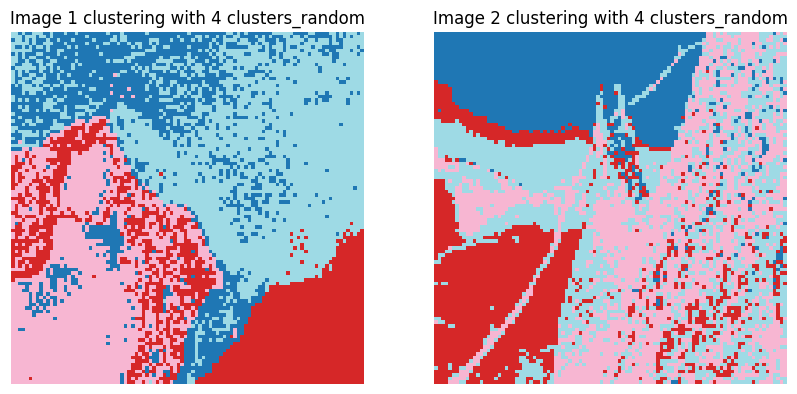

Time taken for k=4, initialization=random: 13.93 seconds
Normalized Clustering for image 1 for 4 with kmeans++ initialization:
Performing K-Means...
Cannot visualize more than 3 dimensions.
GIF saved at /kaggle/working/img1/clustering_img1_nb_cluster4_init_kmeans++.gif
Image 1 clustering done for 4clusters, initializing with random centers
Normalized Clustering for image 2 for 4 withkmeans++ initialization:
Performing K-Means...
Cannot visualize more than 3 dimensions.
GIF saved at /kaggle/working/img2/clustering_img2_nb_cluster4_init_kmeans++.gif
Image 1 clustering done for 4clusters, initializing with random centers


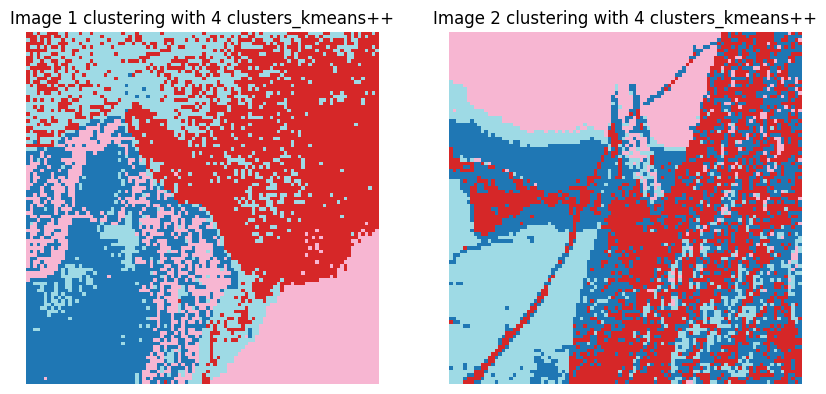

Time taken for k=4, initialization=kmeans++: 13.28 seconds
Total time for all configurations: 503.14 seconds


In [37]:
# Normalized Cut
start_time_total = time.time()
eigenvalues1, eigenvectors1 = compute_eigen_normalized(similarity_matrix1)
print("Eigenvalues and vectors done for img 1!")
eigenvalues2, eigenvectors2 = compute_eigen_normalized(similarity_matrix2)
print("Eigenvalues and vectors done for img 2!")

nb_clusters = [2,3,4]
initialization = ["random", "kmeans++"]

for k in nb_clusters:
    for init in initialization:
        start_time = time.time()
        print(f"Normalized Clustering for image 1 for {k} with {init} initialization:")
        clusters1 = normalized_spectral_clustering(eigenvalues1, eigenvectors1,
                                                   k,
                                                   max_iter = 100,
                                                   tol = 1e-6,
                                                   init_method = init,
                                                   output_dir = output_path,
                                                   name = "img1",img_shape = img1.shape)
        create_gif("img1", output_path, k=k, initialize=init, max_iter=100)
        print(f'Image 1 clustering done for {k}clusters, initializing with random centers')
    
        print(f"Normalized Clustering for image 2 for {k} with{init} initialization:")
        clusters2 = normalized_spectral_clustering(eigenvalues2, eigenvectors2,
                                                   k,
                                                   max_iter = 100,
                                                   tol = 1e-6,
                                                   init_method = init,
                                                   output_dir = output_path,
                                                   name = "img2",img_shape = img2.shape)
        create_gif("img2", output_path, k=k, initialize=init, max_iter=100)
        print(f'Image 1 clustering done for {k}clusters, initializing with random centers')
        
        #visualize the clustering
        clusters1_reshaped = clusters1.reshape(img1.shape[:2])
        clusters2_reshaped = clusters2.reshape(img2.shape[:2])
        
        # Visualize the clustering results
        plt.figure(figsize=(10, 10))
        
        # Image 1 clustering
        plt.subplot(1, 2, 1)
        plt.imshow(clusters1_reshaped, cmap='tab20')
        plt.title(f"Image 1 clustering with {k} clusters_{init}")
        plt.axis('off')
        
        # Image 2 clustering
        plt.subplot(1, 2, 2)
        plt.imshow(clusters2_reshaped, cmap='tab20')
        plt.title(f"Image 2 clustering with {k} clusters_{init}")
        plt.axis('off')
        
        plt.show()
        # Print the time taken for this configuration
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Time taken for k={k}, initialization={init}: {elapsed_time:.2f} seconds")

end_time_total = time.time()
total_elapsed_time = end_time_total - start_time_total
print(f"Total time for all configurations: {total_elapsed_time:.2f} seconds")

## Ratio Cut

In [38]:
def compute_eigen_Ratio(similarity_matrix):
    # Compute Degree matrix
    D = np.diag(np.sum(similarity_matrix, axis=1))
    # Compute Laplacian
    print("Computing Degree matrix and Laplacian...")
    L = D - similarity_matrix
    # Compute eigenvectors of L
    print("Computing Eigen vectors...")
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    return eigenvalues, eigenvectors
    
def Ratio_Cut(
    eigenvalues, 
    eigenvectors,
    k,
    max_iter=100,
    tol=1e-6,
    init_method="random",
    output_dir="output",
    name="img",
    img_shape=None
):
    index = np.argsort(eigenvalues)
    eigenvectors = eigenvectors[:, index]
    U = eigenvectors[:, 1:1+k].real
    
    # Define a save callback function
    def save_callback(clusters, iteration):
        if img_shape is not None:
            save_iteration_visualization(name + '_ratio_cut', img_shape, clusters, k, iteration, init_method, output_dir)

    # Apply k-means to rows of T
    print("Performing K-Means...")
    clusters, _ = kmeans(
        U,
        k,
        max_iter=max_iter,
        tol=tol,
        init_method=init_method,
        save_callback=save_callback
    )

    # Visualize Eigen-space
    visualize_eigen_space(U, clusters, k, f"{name}_RatioCut", init_method, output_dir, init_method)

    return clusters

Computing Degree matrix and Laplacian...
Computing Eigen vectors...
Eigenvalues and vectors done for img 1!
Computing Degree matrix and Laplacian...
Computing Eigen vectors...
Eigenvalues and vectors done for img 2!
Ratio Cut for image 1 for 2 with random initialization:
Performing K-Means...


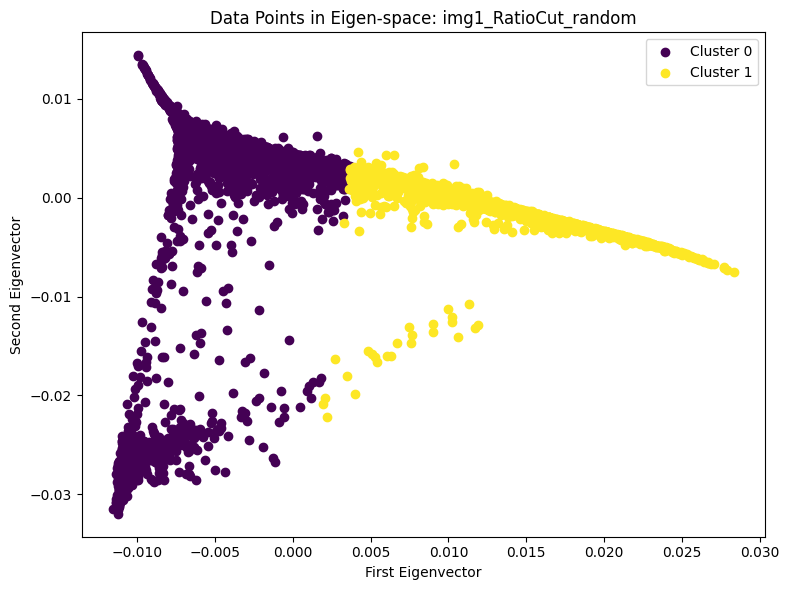

/tmp/ipykernel_24/1561842593.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


GIF saved at /kaggle/working/img1_ratio_cut/clustering_img1_ratio_cut_nb_cluster2_init_random.gif
Image 1 clustering done for 2clusters, initializing with random centers
Ratio_Cut for image 2 for 2 withrandom initialization:
Performing K-Means...


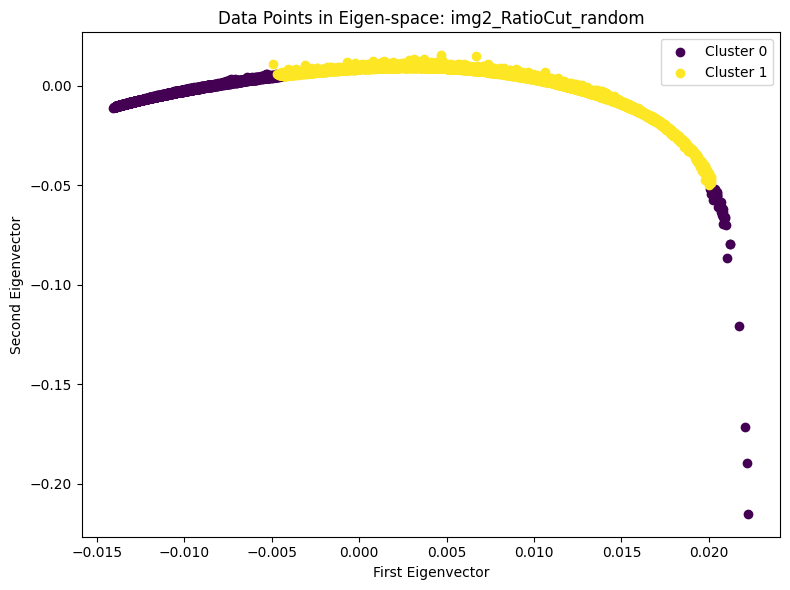

GIF saved at /kaggle/working/img2_ratio_cut/clustering_img2_ratio_cut_nb_cluster2_init_random.gif
Image 1 clustering done for 2clusters, initializing with random centers


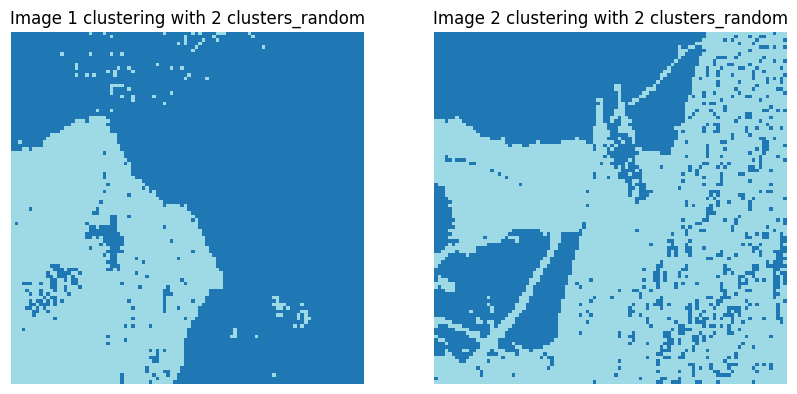

Time taken for k=2, initialization=random: 6.65 seconds
Ratio Cut for image 1 for 2 with kmeans++ initialization:
Performing K-Means...


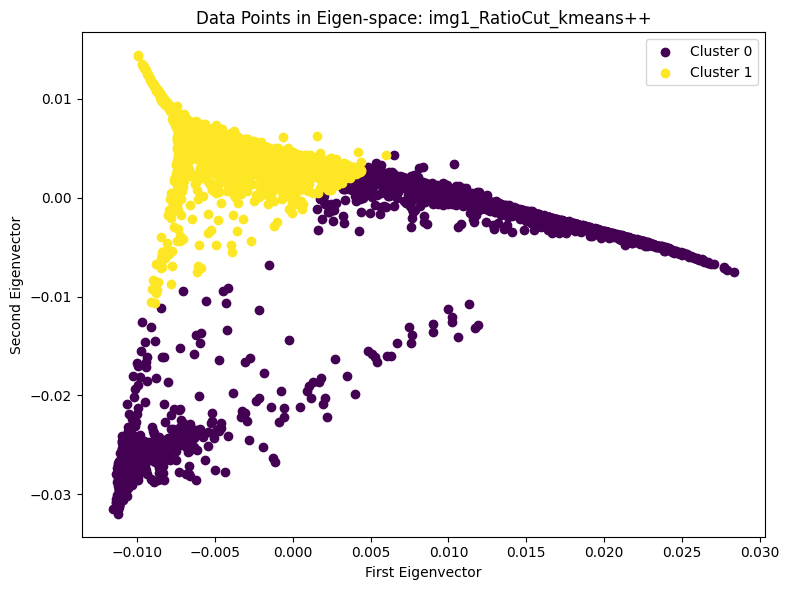

GIF saved at /kaggle/working/img1_ratio_cut/clustering_img1_ratio_cut_nb_cluster2_init_kmeans++.gif
Image 1 clustering done for 2clusters, initializing with random centers
Ratio_Cut for image 2 for 2 withkmeans++ initialization:
Performing K-Means...


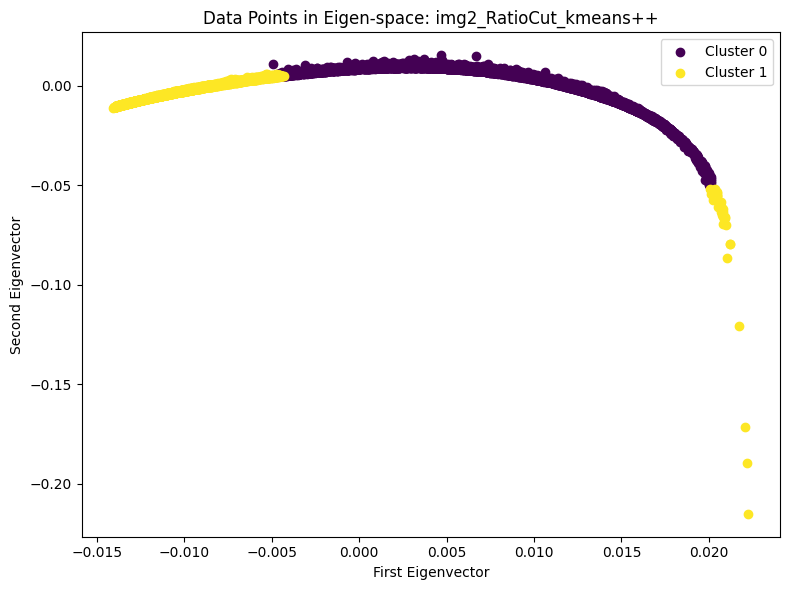

GIF saved at /kaggle/working/img2_ratio_cut/clustering_img2_ratio_cut_nb_cluster2_init_kmeans++.gif
Image 1 clustering done for 2clusters, initializing with random centers


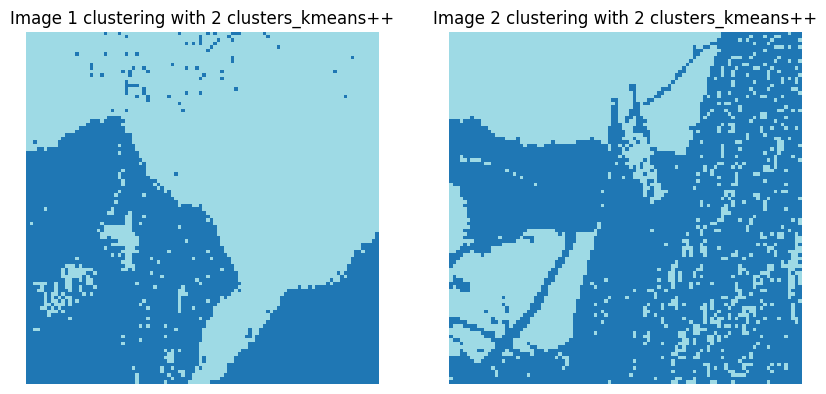

Time taken for k=2, initialization=kmeans++: 6.07 seconds
Ratio Cut for image 1 for 3 with random initialization:
Performing K-Means...


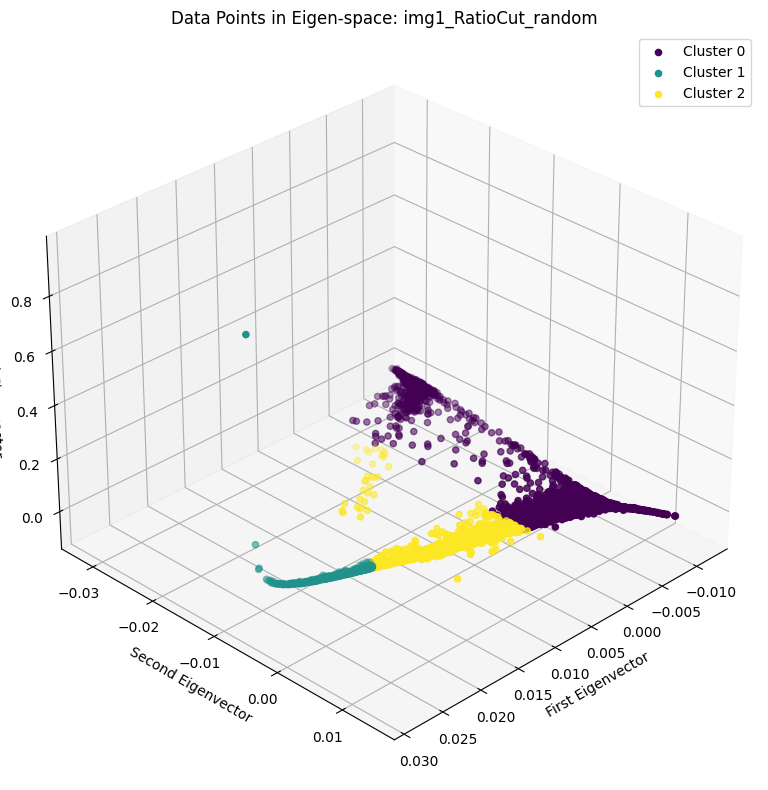

GIF saved at /kaggle/working/img1_ratio_cut/clustering_img1_ratio_cut_nb_cluster3_init_random.gif
Image 1 clustering done for 3clusters, initializing with random centers
Ratio_Cut for image 2 for 3 withrandom initialization:
Performing K-Means...


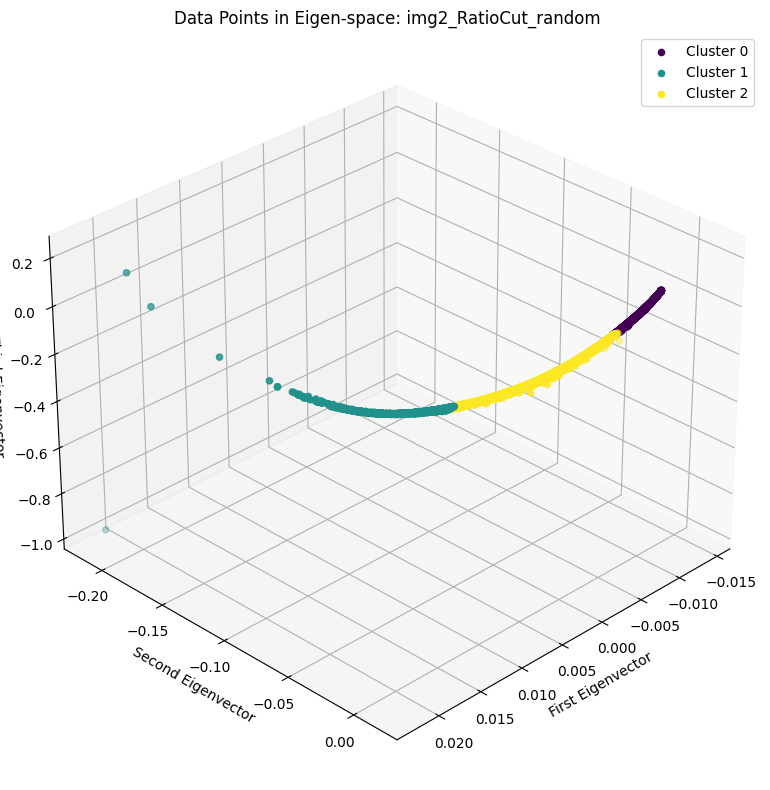

GIF saved at /kaggle/working/img2_ratio_cut/clustering_img2_ratio_cut_nb_cluster3_init_random.gif
Image 1 clustering done for 3clusters, initializing with random centers


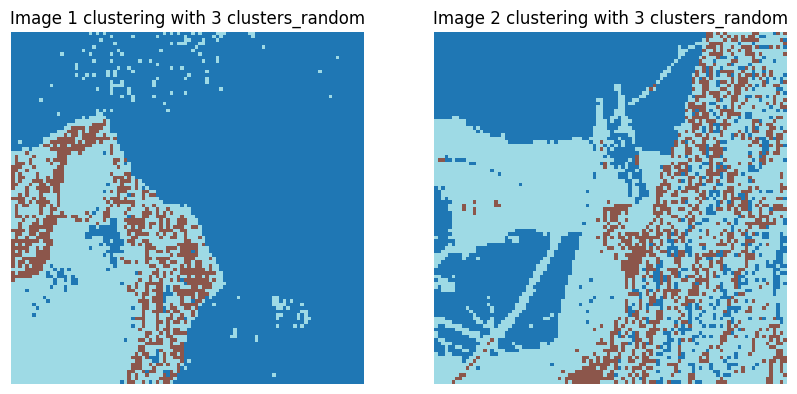

Time taken for k=3, initialization=random: 12.11 seconds
Ratio Cut for image 1 for 3 with kmeans++ initialization:
Performing K-Means...


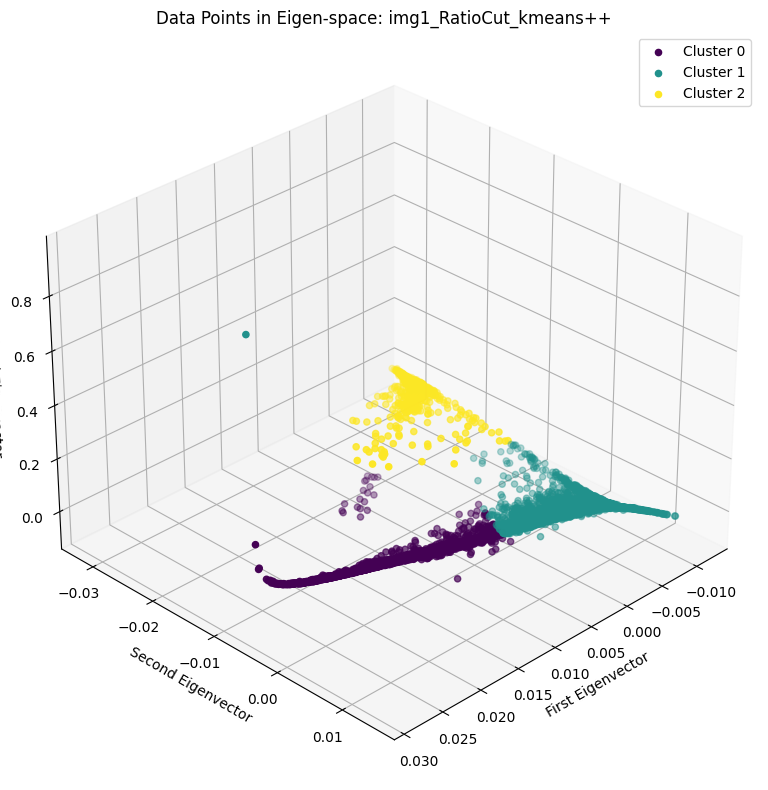

GIF saved at /kaggle/working/img1_ratio_cut/clustering_img1_ratio_cut_nb_cluster3_init_kmeans++.gif
Image 1 clustering done for 3clusters, initializing with random centers
Ratio_Cut for image 2 for 3 withkmeans++ initialization:
Performing K-Means...


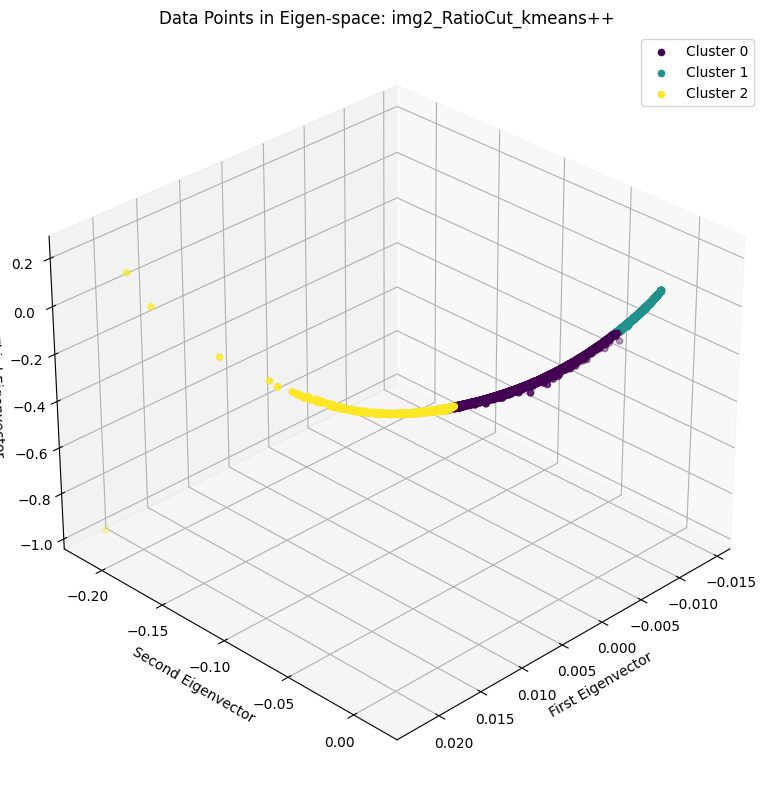

GIF saved at /kaggle/working/img2_ratio_cut/clustering_img2_ratio_cut_nb_cluster3_init_kmeans++.gif
Image 1 clustering done for 3clusters, initializing with random centers


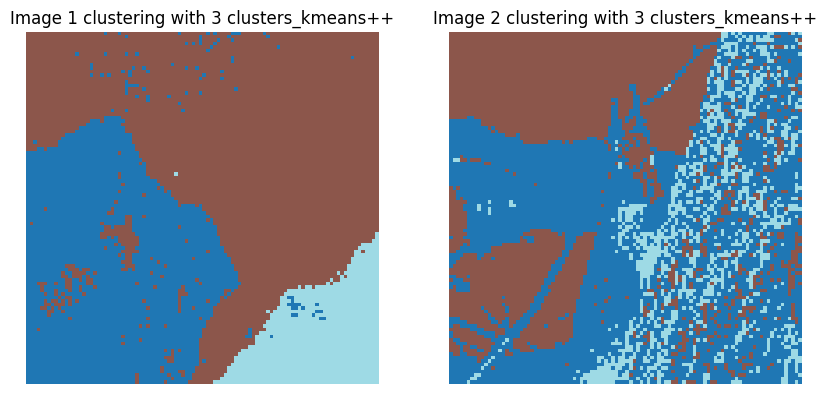

Time taken for k=3, initialization=kmeans++: 11.04 seconds
Ratio Cut for image 1 for 4 with random initialization:
Performing K-Means...
Cannot visualize more than 3 dimensions.
GIF saved at /kaggle/working/img1_ratio_cut/clustering_img1_ratio_cut_nb_cluster4_init_random.gif
Image 1 clustering done for 4clusters, initializing with random centers
Ratio_Cut for image 2 for 4 withrandom initialization:
Performing K-Means...
Cannot visualize more than 3 dimensions.
GIF saved at /kaggle/working/img2_ratio_cut/clustering_img2_ratio_cut_nb_cluster4_init_random.gif
Image 1 clustering done for 4clusters, initializing with random centers


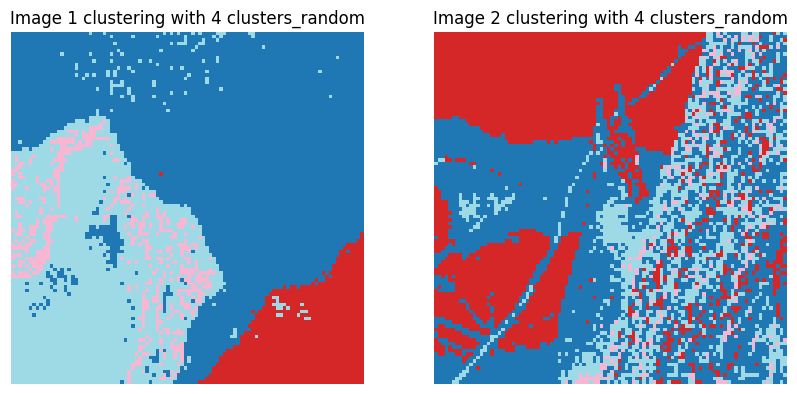

Time taken for k=4, initialization=random: 13.03 seconds
Ratio Cut for image 1 for 4 with kmeans++ initialization:
Performing K-Means...
Cannot visualize more than 3 dimensions.
GIF saved at /kaggle/working/img1_ratio_cut/clustering_img1_ratio_cut_nb_cluster4_init_kmeans++.gif
Image 1 clustering done for 4clusters, initializing with random centers
Ratio_Cut for image 2 for 4 withkmeans++ initialization:
Performing K-Means...
Cannot visualize more than 3 dimensions.
GIF saved at /kaggle/working/img2_ratio_cut/clustering_img2_ratio_cut_nb_cluster4_init_kmeans++.gif
Image 1 clustering done for 4clusters, initializing with random centers


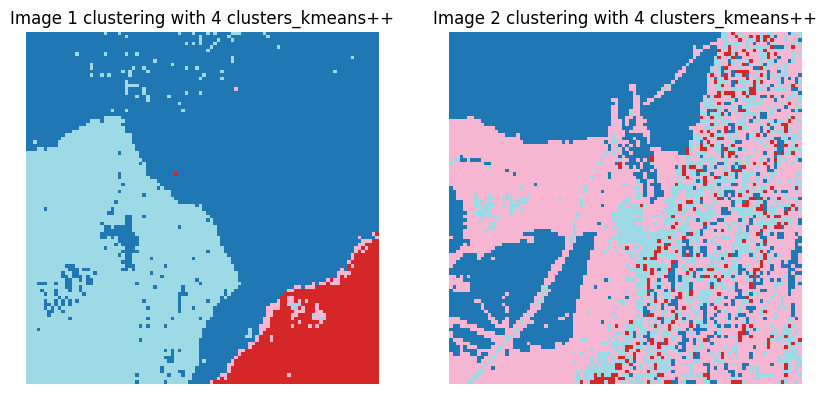

Time taken for k=4, initialization=kmeans++: 8.17 seconds
Total time for all configurations: 393.23 seconds


In [39]:
# Ratio Cut
start_time_total = time.time()

eigenvalues1, eigenvectors1 = compute_eigen_Ratio(similarity_matrix1)
print("Eigenvalues and vectors done for img 1!")
eigenvalues2, eigenvectors2 = compute_eigen_Ratio(similarity_matrix2)
print("Eigenvalues and vectors done for img 2!")

nb_clusters = [2,3,4]
initialization = ["random", "kmeans++"]

for k in nb_clusters:
    for init in initialization:
        start_time = time.time()
        print(f"Ratio Cut for image 1 for {k} with {init} initialization:")
        clusters1 = Ratio_Cut(eigenvalues1, eigenvectors1,
                                                   k,
                                                   max_iter = 100,
                                                   tol = 1e-6,
                                                   init_method = init,
                                                   output_dir = output_path,
                                                   name = "img1",img_shape = img1.shape)
        create_gif('img1_ratio_cut', output_path, k=k, initialize=init, max_iter=100)
        print(f'Image 1 clustering done for {k}clusters, initializing with random centers')
    
        print(f"Ratio_Cut for image 2 for {k} with{init} initialization:")
        clusters2 = Ratio_Cut(eigenvalues2, eigenvectors2,
                                                   k,
                                                   max_iter = 100,
                                                   tol = 1e-6,
                                                   init_method = init,
                                                   output_dir = output_path,
                                                   name = "img2",img_shape = img2.shape)
        create_gif('img2_ratio_cut', output_path, k=k, initialize=init, max_iter=100)
        print(f'Image 1 clustering done for {k}clusters, initializing with random centers')
        
        #visualize the clustering
        clusters1_reshaped = clusters1.reshape(img1.shape[:2])
        clusters2_reshaped = clusters2.reshape(img2.shape[:2])
        
        # Visualize the clustering results
        plt.figure(figsize=(10, 10))
        
        # Image 1 clustering
        plt.subplot(1, 2, 1)
        plt.imshow(clusters1_reshaped, cmap='tab20')
        plt.title(f"Image 1 clustering with {k} clusters_{init}")
        plt.axis('off')
        
        # Image 2 clustering
        plt.subplot(1, 2, 2)
        plt.imshow(clusters2_reshaped, cmap='tab20')
        plt.title(f"Image 2 clustering with {k} clusters_{init}")
        plt.axis('off')
        
        plt.show()
        # Print the time taken for this configuration
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Time taken for k={k}, initialization={init}: {elapsed_time:.2f} seconds")

# Measure the total time for all runs
end_time_total = time.time()
total_elapsed_time = end_time_total - start_time_total
print(f"Total time for all configurations: {total_elapsed_time:.2f} seconds")